# Introduction by Examples (Reasoner)
We briefly introduce the fundamental concepts of alphaILP thorugh self-contained examples. We first demonstrate how to build a differentiable forward reasoner and perform prediction on visual scenes.
- Acknowledgement on side bar, SPAICER!! 
- Link to more SPAICER specific example
- Logistics with Zihan, 

## Solving Kandinsky Patterns
In this introduction, we solve the following kandinsky patterns:

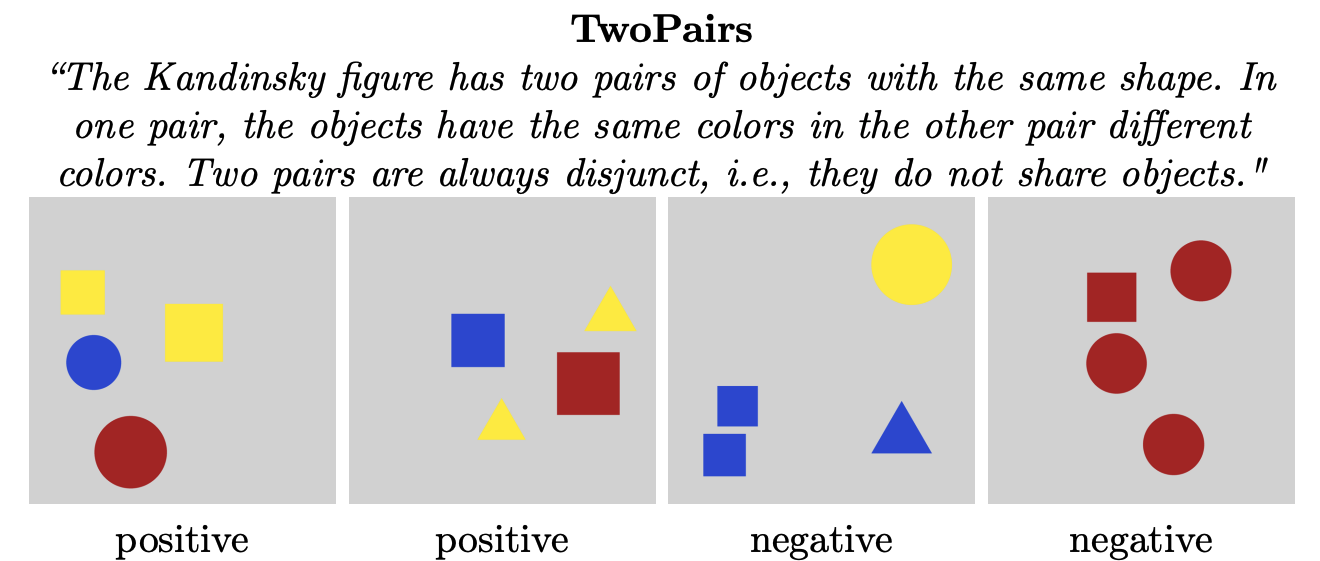

In [4]:
from IPython.display import Image
Image('imgs/twopairs_examples.png')

## Lanuage Definition
To start writing logic programs, we need to specify a set of symbols we can use, which is called as **language**.
<!-- A language  $\mathcal{L}$ is a tuple $(\mathcal{P}, \mathcal{F}, \mathcal{T}, \mathcal{V})$, where $\mathcal{P}$ is a set of predicates, $\mathcal{F}$ is a set of function symbols, $\mathcal{T}$ is a set of constants, and $\mathcal{V}$ is a set of variables.-->

We define language in text files in `data/lang/dataset-type/dataset-name/`.
### Predicates 
Predicates are written in `preds.txt` file. The format is `name:arity:data_types`. Each predicate should be specified line by line.
For example,
```
pos:1:image
same_color_pair:2:object,object
same_shape_pair:2:object,object
diff_color_pair:2:object,object
diff_shape_pair:2:object,object
diff_color:2:color,color
diff_shape:2:shape,shape
```

### Neural Predicates 
Neural predicates are written in `neural_preds.txt` file. The format is `name:arity:data_types`. Each predicate should be specified line by line.
For example,
```
in:2:object,image
color:2:object,color
shape:2:object,shape
```
Valuation functions for each neural predicate should be defined in `valuation_func.py` and be registered in `valuation.py`.

### Constants
Constants are written in `consts.txt`. The format is `data_type:names`. Each constant should be specified line by line. For example,
```
object:obj0,obj1,obj2,obj3,obj4
color:red,yellow,blue
shape:square,circle,triangle
image:img
```

The defined language can be loaded by `logic_utils.get_lang`.

In [84]:
# Load a defined language
import sys
sys.path.append('src/')
from src.logic_utils import get_lang

lark_path = 'src/lark/exp.lark'
lang_base_path = 'data/lang/'
lang, _clauses, bk_clauses, bk, atoms = get_lang(
        lark_path, lang_base_path, 'kandinsky', 'twopairs')

## Writing Logic Programs
By using the defined symbols, you can write logic programs, for example,
```
kp(X):-in(O1,X),in(O2,X),in(O3,X),in(O4,X),same_shape_pair(O1,O2),same_color_pair(O1,O2),same_shape_pair(O3,O4),diff_color_pair(O3,O4).
same_shape_pair(X,Y):-shape(X,Z),shape(Y,Z).
same_color_pair(X,Y):-color(X,Z),color(Y,Z).
diff_color_pair(X,Y):-color(X,Z),color(Y,W),diff_color(Z,W).
```
Clauses should be written in `clauses.txt` or `bk_clauses.txt`.

In [75]:
# Write a logic program as text
clauses_str = """
kp(X):-in(O1,X),in(O2,X),in(O3,X),in(O4,X),same_shape_pair(O1,O2),same_color_pair(O1,O2),same_shape_pair(O3,O4),diff_color_pair(O3,O4).
same_shape_pair(X,Y):-shape(X,Z),shape(Y,Z).
same_color_pair(X,Y):-color(X,Z),color(Y,Z).
diff_color_pair(X,Y):-color(X,Z),color(Y,W),diff_color(Z,W).
"""
# Parse the text to logic program
from fol.data_utils import DataUtils
du = DataUtils(lark_path, lang_base_path, args.dataset_type, args.dataset)
clauses = []
for line in clauses_str.split('\n')[1:-1]:
    print(line)
    clauses.append(du.parse_clause(line, lang))
    
clauses = [clauses[0]]
#bk_clauses = clauses[1:]

kp(X):-in(O1,X),in(O2,X),in(O3,X),in(O4,X),same_shape_pair(O1,O2),same_color_pair(O1,O2),same_shape_pair(O3,O4),diff_color_pair(O3,O4).
same_shape_pair(X,Y):-shape(X,Z),shape(Y,Z).
same_color_pair(X,Y):-color(X,Z),color(Y,Z).
diff_color_pair(X,Y):-color(X,Z),color(Y,W),diff_color(Z,W).


## Specify Hyperparameters

In [76]:
class Args:
    dataset_type = 'kandinsky'
    dataset = 'twopairs'
    batch_size = 2
    num_objects = 6
    no_cuda = True
    num_workers = 4
    program_size = 1
    epochs = 20
    lr = 1e-2
    infer_step = 3
    term_depth = 2
    no_train = False
    plot = False
    small_data = False

args = Args()
device = torch.device('cpu')

## Build a Reasoner
Import the neuro-symbolic forward reasoner.

In [86]:
from percept import SlotAttentionPerceptionModule, YOLOPerceptionModule
from valuation import SlotAttentionValuationModule, YOLOValuationModule
from facts_converter import FactsConverter
from nsfr import NSFReasoner
from logic_utils import build_infer_module, build_clause_infer_module
import torch

PM = YOLOPerceptionModule(e=args.num_objects, d=11, device=device)
VM = YOLOValuationModule(
            lang=lang, device=device, dataset=args.dataset)

FC = FactsConverter(lang=lang, perception_module=PM,
                        valuation_module=VM, device=device)
IM = build_infer_module(clauses, bk_clauses, atoms, lang,
                            m=1, infer_step=3, device=device, train=False)
CIM = build_clause_infer_module(clauses, bk_clauses, atoms, lang,
                            m=len(clauses), infer_step=3, device=device)
# Neuro-Symbolic Forward Reasoner
NSFR = NSFReasoner(perception_module=PM, facts_converter=FC,
                       infer_module=IM, clause_infer_module=CIM, atoms=atoms, bk=bk, clauses=clauses)

Loading YOLO model...


## Load Data

In [87]:
from nsfr_utils import get_data_loader  # get torch data loader
import matplotlib.pyplot as plt

train_loader, val_loader,  test_loader = get_data_loader(args)

# print 4 examples
#imgs = [img.detach().numpy() for img, label in train_loader][:4]
#labels = [label for img, label in train_loader][:4]

#fig, ax = plt.subplots(1, 4)
#for i in range(4):
#    ax[i].imshow(imgs[i])

In [95]:
from train import predict
acc_th = predict(NSFR, train_loader, args, device, th=0.5)
print('Accuracy: ', acc_th[0])

13it [00:22,  1.75s/it]

Accuracy:  1.0
